In [22]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import table

In [23]:
import numpy as np
import scipy
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from simulation_data import get
from simulation_data.galaxies import GalaxyPopulation
my_galaxy_population = GalaxyPopulation()
from simulation_data.galaxies.galaxy import age_profile, get_star_formation_history, get_galaxy_particle_data, get_stellar_assembly_data, metallicity_profile, metals_profile, gasmetals_profile, metals_density_profile, metals_particle_profile, get_insitu, histmetals_density_profile, halfmass_rad_stars, stellar_density, gasmetals_density_profile, effective_yield, stellar_gas_densities, gasmetals_only, stellar_gas_metallicities, gas_mass, bimodal_check, starmetals_only, stellar_mass, get_stellar_age, gas_consumption

redshift = 0.7

In [24]:
with h5py.File('galaxy_population_data_'+str(redshift)+'.hdf5', 'r') as f:
    ids = f['ids'][:]
    median_age = f['median_age'][:]
    halfmass_radius = f['halfmass_radius'][:]
    total_mass = f['total_mass'][:]
#     halflight_radius_U = f['halflight_radius_U'][:]
#     halflight_radius_V = f['halflight_radius_V'][:]
#     halflight_radius_I = f['halflight_radius_I'][:]
#     newbin_current_SFR = f['newbin_current_SFR'][:]
#     maximum_merger_ratio_30kpc_current_fraction = f['maximum_merger_ratio_30kpc_current_fraction'][:]
    FeH_Re = f['FeH_Re'][:]
    MgFe_Re = f['MgFe_Re'][:]
    MgH_Re = f['MgH_Re'][:]
    FeH_1kpc = f['FeH_1kpc'][:]
    MgFe_1kpc = f['MgFe_1kpc'][:]
    MgH_1kpc = f['MgH_1kpc'][:]
    gas_mass_1kpc = f['gas_mass_1kpc'][:]
    stellar_mass_1kpc = f['stellar_mass_1kpc'][:]
#     OH_Re = f['OH_Re']
#     OH_1kpc = f['OH_1kpc']
#     OFe_Re = f['OFe_Re']
#     OFe_1kpc = f['OFe_1kpc']
#     FeH_gas_Re = f['FeH_gas_Re']
#     FeH_gas_1kpc = f['FeH_gas_1kpc']
#     OH_gas_Re = f['FeH_gas_Re']
#     OH_gas_1kpc = f['FeH_gas_1kpc']
    percentile_age = f['percentile_age'][:]

In [25]:
import warnings
warnings.filterwarnings('ignore')

starforming_selection = (np.log10(gas_mass_1kpc/(gas_mass_1kpc+stellar_mass_1kpc))>-3) #-4)
quiescent_selection = (np.log10(gas_mass_1kpc/(gas_mass_1kpc+stellar_mass_1kpc))<=-3) #-4)

print(len(ids[starforming_selection]))
print(len(ids[quiescent_selection]))

839
1618


In [26]:
# credit: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [27]:
# start with a dictionary
sample_template = {
    'name': 'galaxy_name       ',
    'redshift': np.nan,
    'logMstar': np.nan,
    'Re': np.nan,              # kpc
    'x_err': np.nan,
    'age': np.nan,              # Gyr
    'age_err': np.nan,
    '[Fe/H]': np.nan,
    '[Fe/H]_err': np.nan,
    '[Mg/Fe]': np.nan,
    '[Mg/Fe]_err': np.nan,
    '[Mg/H]': np.nan,
    '[Mg/H]_err': np.nan,
}

# convert each value to a list of 100 identical objects
for k, v in sample_template.items():
    sample_template[k] = [v]*100

# convert dictionary of lists to a Table object 
sample_template = table.Table(sample_template)


sample_template[0:5]

name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [28]:
########################
# Kriek et al. (2016)
########################
# 1 galaxy, MOSFIRE spectrum, fit with Alf

kriek16 = sample_template[0:1].copy()
kriek16.meta['label'] = 'z~2 (Kriek et al. 2016)'

kriek16['name'] = 'COSMOS-11494'
kriek16['redshift'] = 2.1
kriek16['logMstar'] = 11.5
kriek16['Re'] = 2.1
kriek16['x_err'] = 0.1
kriek16['age'] = 2.71
kriek16['age_err'] = 0.22
kriek16['[Fe/H]'] = -0.25
kriek16['[Fe/H]_err'] = 0.11
kriek16['[Mg/Fe]'] = 0.59
kriek16['[Mg/Fe]_err'] = 0.11
kriek16['[Mg/H]'] = kriek16['[Mg/Fe]'] + kriek16['[Fe/H]']
kriek16['[Mg/H]_err'] = np.sqrt( kriek16['[Mg/Fe]_err']**2 + kriek16['[Fe/H]_err']**2 )

# print out table
kriek16



name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
COSMOS-11494,2.1,11.5,2.1,0.1,2.71,0.22,-0.25,0.11,0.59,0.11,0.33999999999999997,0.15556349186104046


In [29]:
########################
# Beverage et al. (2021)
########################
# 67 galaxies

name = []
rredshift = []
logMstar = []
Re = []
age = []
age_err = []
FeH = []
FeH_err = []
MgFe = []
MgFe_err = []
MgH = []
MgH_err = []

with open('beverage21_legacDR2_results.dat', 'r') as f:
    next(f)
    for row in f:
        line=row.rstrip().split(' ')
#         line = [float(bang) for bang in bing[1:]]
        if float(line[3]) < 10.5:
            pass
        else:
            name.append(line[0])
            rredshift.append(float(line[1]))
            logMstar.append(float(line[3]))
            Re.append(float(line[6]))
            age.append(float(line[21]))
            age_err.append((float(line[22])+float(line[23])/2))
            FeH.append(float(line[9]))
            FeH_err.append((float(line[10])+float(line[11])/2))
            MgFe.append(float(line[15]))
            MgFe_err.append((float(line[16])+float(line[17])/2))
            MgH.append(float(line[12]))
            MgH_err.append((float(line[13])+float(line[14])/2))
        
bev21 = sample_template[0:len(name)].copy()
bev21.meta['label'] = 'z~0.7 (Beverage et al. 2021)'

bev21['name'] = name
bev21['redshift'] = rredshift 
bev21['logMstar'] = logMstar
bev21['Re'] = Re 
bev21['x_err'] = np.full(len(name), 0.1)
bev21['age'] = 10**np.array(age) 
bev21['age_err'] = 10**np.array(age_err) 
bev21['[Fe/H]'] = FeH
bev21['[Fe/H]_err'] = FeH_err
bev21['[Mg/Fe]'] = MgFe
bev21['[Mg/Fe]_err'] = MgFe_err
bev21['[Mg/H]'] = MgH
bev21['[Mg/H]_err'] = MgH_err

# print out table
bev21

name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
M10_187035,0.6178,10.8601,4.3386,0.1,8.13392193567162,1.1019198334508078,-0.4203,0.03855,0.333,0.0337,-0.0882,0.04775
M10_213772,0.7004,11.6928,7.3291,0.1,7.301296749459656,1.0916916788093647,-0.1732,0.0435,0.1084,0.02915,-0.0623,0.049550000000000004
M10_218656,0.6183,10.8536,2.6266,0.1,8.120822162499834,1.1780127744628046,-0.4795,0.08255,0.3169,0.0637,-0.1633,0.0761
M10_219083,0.7054,11.0723,6.3296,0.1,5.8156732771851445,1.1485502481999437,-0.2938,0.061149999999999996,0.3068,0.0615,0.0128,0.09040000000000001
M10_225441,0.6823,10.6554,0.7695,0.1,2.1325538179462007,1.0693010665477825,-0.1586,0.0576,0.2401,0.04995,0.0831,0.06835
M10_227672,0.6093,10.6166,3.542,0.1,5.001496854402788,1.2139477653658286,-0.3443,0.07225,0.3348,0.0664,-0.0144,0.1046
M10_228380,0.6114,11.1953,6.7543,0.1,7.950601750844197,1.0987528131180708,-0.428,0.0403,0.3113,0.03455,-0.1166,0.04325
M10_230983,0.6961,10.9875,4.0335,0.1,5.3777424596344225,1.4055619763755018,-0.1792,0.1227,0.2368,0.0743,0.0474,0.14295
M10_231544,0.6548,10.8046,2.2791,0.1,3.627438014764578,1.157310784094042,-0.1353,0.0594,0.2985,0.04819999999999999,0.162,0.06795


In [30]:
########################
# Kriek et al. (2019)
########################
# 5 galaxies, LRIS+MOSFIRE spectra, fit with Alf

kriek19 = sample_template[0:3].copy()
kriek19.meta['label'] = 'z~1.4 (Kriek et al. 2019)'

kriek19['name'] = [214340, 213931, 214695] #217249, 213947, 
kriek19['redshift'] = [1.418, 1.399, 1.396] #1.377, 1.397, 
kriek19['logMstar'] = [10.80, 11.73, 11.18] #10.61, 10.87, 
kriek19['Re'] = 10**np.array([0.52, 0.62, 0.29]) #-0.3, -0.2, 
kriek19['x_err'] = [0.1, 0.1, 0.1]
kriek19['age'] = [3.8, 3.1, 4.5] #3.0, 3.0, 
kriek19['age_err'] = [3.0, 0.2, 2.1] # mean of upper and lower uncertainty #0.5, 0.6, 
kriek19['[Fe/H]'] = [-0.42, -0.27, -0.20] #-1.03, -0.89, 
kriek19['[Fe/H]_err'] = [0.20, 0.07, 0.20] # mean of upper and lower uncertainty #0.37, 0.46, 
kriek19['[Mg/Fe]'] = [0.22, 0.44, 0.28] #0.52, 0.57, 
kriek19['[Mg/Fe]_err'] = [0.17, 0.08, 0.15] #0.32, 0.28, 
kriek19['[Mg/H]'] = kriek19['[Mg/Fe]'] + kriek19['[Fe/H]']
kriek19['[Mg/H]_err'] = np.sqrt( kriek19['[Mg/Fe]_err']**2 + kriek19['[Fe/H]_err']**2 )

# following the paper, we discard the first two galaxies because very young
# and with uncertain abundance measurements

# kriek19_discarded = kriek19[0:2]
# kriek19_discarded.meta['label'] = 'Kriek et al. (2019) discarded'
# kriek19 = kriek19[2:]

# print out table
kriek19



name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
214340,1.418,10.8,3.311311214825911,0.1,3.8,3.0,-0.42,0.2,0.22,0.17,-0.19999999999999998,0.2624880949681338
213931,1.399,11.73,4.168693834703354,0.1,3.1,0.2,-0.27,0.07,0.44,0.08,0.16999999999999998,0.1063014581273465
214695,1.396,11.18,1.9498445997580451,0.1,4.5,2.1,-0.2,0.2,0.28,0.15,0.08000000000000002,0.25


In [31]:
########################
# Jafariyazani et al. (2020)
########################
# 1 galaxy, MOSFIRE spectrum, fit with Alf

jafa20 = sample_template[0:1].copy()
jafa20.meta['label'] = 'z~2 (Jafariyazani et al. 2020)'

jafa20['name'] = 'MRG-M0138'
jafa20['redshift'] = 1.98
jafa20['logMstar'] = 11.69
jafa20['Re'] = 4.8
jafa20['x_err'] = 0.1
jafa20['age'] = 1.37
jafa20['age_err'] = 0.11
jafa20['[Fe/H]'] = 0.26
jafa20['[Fe/H]_err'] = 0.04
jafa20['[Mg/Fe]'] = 0.51
jafa20['[Mg/Fe]_err'] = 0.05
jafa20['[Mg/H]'] = jafa20['[Mg/Fe]'] + jafa20['[Fe/H]']
jafa20['[Mg/H]_err'] = np.sqrt( jafa20['[Mg/Fe]_err']**2 + jafa20['[Fe/H]_err']**2 )

# print out table
jafa20



name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
MRG-M0138,1.98,11.69,4.8,0.1,1.37,0.11,0.26,0.04,0.51,0.05,0.77,0.06403124237432849


In [32]:
########################
# Carnall et al. (2021)
########################
# dozens of galaxies at z~1.15

carn21 = sample_template[0:1].copy()
carn21.meta['label'] = 'z~1.15 (Carnall et al. 2021)'

carn21['name'] = 'MRG-M0138'
carn21['redshift'] = 1.15
carn21['logMstar'] = 11.05
carn21['Re'] = None # not found in paper
carn21['x_err'] = 0.1
carn21['age'] = None
carn21['age_err'] = None
carn21['[Fe/H]'] = -0.18
carn21['[Fe/H]_err'] = 0.08
carn21['[Mg/Fe]'] = 0.23
carn21['[Mg/Fe]_err'] = 0.12
carn21['[Mg/H]'] = carn21['[Mg/Fe]'] + carn21['[Fe/H]']
carn21['[Mg/H]_err'] = np.sqrt( carn21['[Mg/Fe]_err']**2 + carn21['[Fe/H]_err']**2 )

# print out table
carn21

name,redshift,logMstar,Re,x_err,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
MRG-M0138,1.15,11.05,nan,0.1,nan,nan,-0.18,0.08,0.23,0.12,0.05000000000000002,0.14422205101855956


In [33]:
# set the marker properties for the plots
elinewidth = 1

kriek16.meta['color'] = 'darkslateblue'
kriek16.meta['markersize'] = 12-7
kriek16.meta['marker'] = 'D'
kriek16.meta['alpha'] = 0.8
kriek16.meta['zorder'] = 100
kriek16.meta['elinewidth'] = elinewidth

kriek19.meta['color'] = 'green'
kriek19.meta['markersize'] = 12-8
kriek19.meta['marker'] = 'v'
kriek19.meta['alpha'] = 0.8
kriek19.meta['zorder'] = 100
kriek19.meta['elinewidth'] = elinewidth

# kriek19_discarded.meta['color'] = 'orange'
# kriek19_discarded.meta['markersize'] = 12
# kriek19_discarded.meta['marker'] = 'o'
# kriek19_discarded.meta['alpha'] = 0.2

jafa20.meta['color'] = 'chocolate'
jafa20.meta['markersize'] = 12-7
jafa20.meta['marker'] = 's'
jafa20.meta['alpha'] = 0.8
jafa20.meta['zorder'] = 100
jafa20.meta['elinewidth'] = elinewidth

carn21.meta['color'] = 'black' #'mediumblue'
carn21.meta['markersize'] = 12-4
carn21.meta['marker'] = 'p'
carn21.meta['alpha'] = 0.8
carn21.meta['zorder'] = 100
carn21.meta['elinewidth'] = elinewidth

bev21.meta['color'] = 'mediumpurple'#'darkgray'
bev21.meta['markersize'] = 6
bev21.meta['markeredgecolor'] = 'white'
bev21.meta['marker'] = 'H'
bev21.meta['alpha'] = 0.8
bev21.meta['elinewidth'] = elinewidth-0.5

fts = 'medium'
ftss = 'small'
ftsss = 'xx-small'


In [34]:
# put samples together
samples = [carn21, bev21] #, kriek19_discarded, jafa20]kriek16, kriek19, jafa20,

# this one is to suppress the line connecting points
for s in samples:
    s.meta['linestyle'] = ''

[Text(0.5, 0, 'log $M_\\ast/M_\\odot$'),
 Text(0, 0.5, '[Mg/H]'),
 (-0.8, 0.9),
 (9.7, 12.0)]

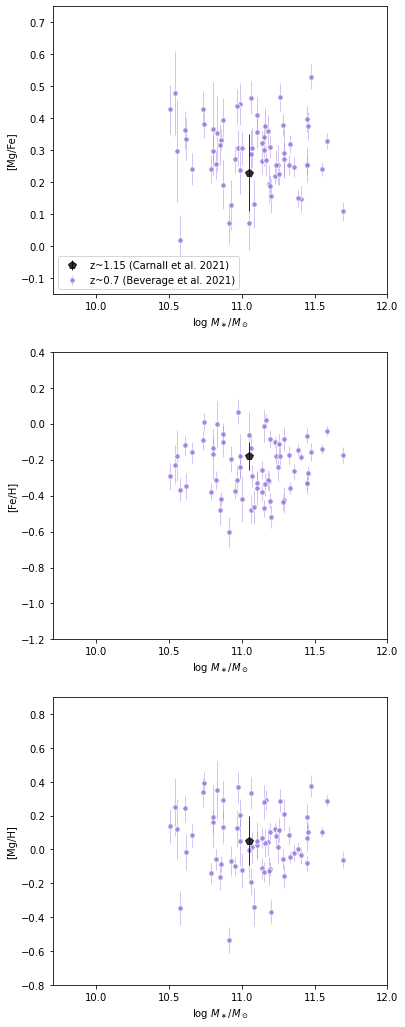

In [35]:

# plot of abundances vs stellar mass

fig, axs = plt.subplots(3, 1, figsize=(6,18))


# [Mg/Fe]
##########

for s in samples:
    axs[0].errorbar(s['logMstar'], s['[Mg/Fe]'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[9.7, 12])
axs[0].legend(loc='lower left')



# [Fe/H]
##########

for s in samples:
    axs[1].errorbar(s['logMstar'], s['[Fe/H]'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Fe/H]',
      ylim=[-1.2, 0.4], xlim=[9.7, 12])


# [Mg/H]
##########

for s in samples:
    axs[2].errorbar(s['logMstar'], s['[Mg/H]'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/H]',
      ylim=[-0.8, 0.9], xlim=[9.7, 12])


[Text(0.5, 0, 'log $M_\\ast/M_\\odot$'),
 Text(0, 0.5, '[Mg/H]'),
 (-0.8, 0.9),
 (10.5, 12.0)]

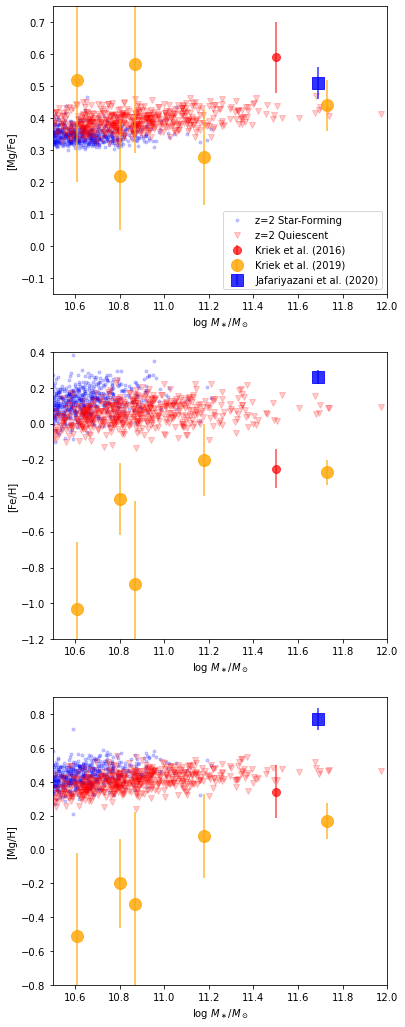

In [27]:

# plot of abundances vs stellar mass

fig, axs = plt.subplots(3, 1, figsize=(6,18))
markersize = 6


# [Mg/Fe]
##########

# z=2 galaxies
axs[0].plot(total_mass[starforming_selection], MgFe_1kpc[starforming_selection], 'b.',
           alpha=0.2, label='z=2 Star-Forming', markersize=markersize, zorder=0)
axs[0].plot(total_mass[quiescent_selection], MgFe_1kpc[quiescent_selection], 'rv',
           alpha=0.2, label='z=2 Quiescent', markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[0].errorbar(s['logMstar'], s['[Mg/Fe]'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[10.5, 12])
axs[0].legend(loc='lower right')



# [Fe/H]
##########

# z=2 galaxies
axs[1].plot(total_mass[starforming_selection], FeH_1kpc[starforming_selection], 'b.',
           alpha=0.2, markersize=markersize, zorder=0)
axs[1].plot(total_mass[quiescent_selection], FeH_1kpc[quiescent_selection], 'rv',
           alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[1].errorbar(s['logMstar'], s['[Fe/H]'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Fe/H]',
      ylim=[-1.2, 0.4], xlim=[10.5, 12])


# [Mg/H]
##########

# z=2 galaxies
axs[2].plot(total_mass[starforming_selection], MgH_1kpc[starforming_selection], 'b.',
           alpha=0.2, markersize=markersize, zorder=0)
axs[2].plot(total_mass[quiescent_selection], MgH_1kpc[quiescent_selection], 'rv',
           alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[2].errorbar(s['logMstar'], s['[Mg/H]'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/H]',
      ylim=[-0.8, 0.9], xlim=[10.5, 12])


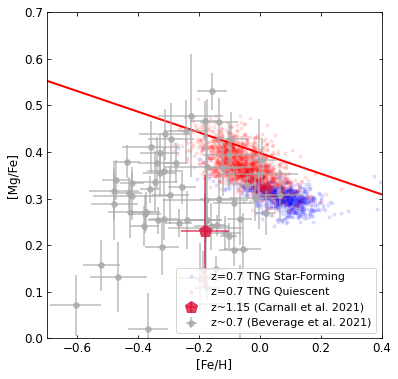

In [45]:

# [Mg/Fe] vs [Fe/H]
####################

param = np.array([-0.22162942,  0.39764619])

def func(x, m, b):
    y = m*x + b
    return y

fig, ax = plt.subplots(figsize=(6,6))

markersize = 6
alpha = 0.1

# z=2 galaxies
ax.plot(FeH_Re[starforming_selection], MgFe_Re[starforming_selection], 'b.',
           alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
ax.plot(FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection], 'r.',
           alpha=alpha, label='z='+str(redshift)+' TNG Quiescent', markersize=markersize, zorder=0)
xx = np.array([-0.7, 0.4])
ax.plot(xx, func(xx, *param), '-', color='r', linewidth=2)

# #fit line
# optParam, pcov = curve_fit(func, FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection])
# xx = np.array([-0.7, 0.4])
# ax.plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, bev21['[Fe/H]'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
# ax.plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

# observations
for s in samples:
    ax.errorbar(s['[Fe/H]'], s['[Mg/Fe]'], xerr=s['[Fe/H]_err'], yerr=s['[Mg/Fe]_err'], **s.meta)

ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]',
      ylim=[0.0, 0.7], xlim=[-0.7, 0.4])
plt.rcParams['axes.labelsize'] = fts+1
ax.tick_params(direction='in', which='both', labelsize=fts, bottom=True, top=True, left=True, right=True)
ax.legend(loc='lower right', fontsize=ftss).set_zorder(200)

plt.savefig('2022 FIGURES\z0p7_MgFeFeH.png', dpi=200, bbox_inches='tight')
plt.show()

In [31]:
print(optParam)
print(optParam2)

[-0.27980555  0.35579377]
[-0.05377257  0.27022599]


In [42]:
kriek16.meta['color'] = 'gray'


kriek19.meta['color'] = 'gray'


# kriek19_discarded.meta['color'] = 'orange'
# kriek19_discarded.meta['markersize'] = 12
# kriek19_discarded.meta['marker'] = 'o'
# kriek19_discarded.meta['alpha'] = 0.2

jafa20.meta['color'] = 'gray'


carn21.meta['color'] = 'black'


bev21.meta['color'] = 'darkgray'
bev21.meta['markersize'] = 6+3
bev21.meta['markeredgecolor'] = 'white'

# put samples together
samples = [carn21, bev21] #, kriek19_discarded, jafa20]kriek16, kriek19, jafa20,

# this one is to suppress the line connecting points
for s in samples:
    s.meta['linestyle'] = ''

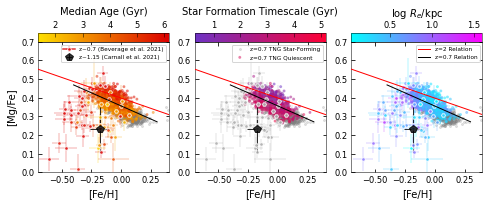

In [46]:

# [Mg/Fe] vs [Fe/H]
####################
fig, axes = plt.subplots(1, 3, figsize=(6.9, 2.95), sharey='row')
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

samples = carn21
for s in samples:
    s.meta['linestyle'] = ''

def func(x, m, b):
    y = m*x + b
    return y

markersize = 4
alpha = 0.2

### MEDIAN AGE ########
vmin_med = min(median_age[quiescent_selection])
vmax_med = max(median_age[quiescent_selection])
hexlist = ['#ffe200', '#dd0000']
colormap_med = get_continuous_cmap(hexlist)
# colormap_med = plt.get_cmap('summer')
norm_med = colors.Normalize(vmin=vmin_med, vmax=vmax_med)
color_med = colormap_med(norm_med(median_age[quiescent_selection]))

### 90 - 10 AGE ########
vmin_age = min(percentile_age[quiescent_selection])
vmax_age = max(percentile_age[quiescent_selection])
hexlist = ['#6d33c6', '#Ff0036']# '#fb2047']
colormap_age = get_continuous_cmap(hexlist)
# colormap_age = plt.get_cmap('summer')
norm_age = colors.Normalize(vmin=vmin_age, vmax=vmax_age)
color_age = colormap_age(norm_age(percentile_age[quiescent_selection]))

### 90 - 10 AGE ########
radius_quiescent = np.log10(np.array(halfmass_radius[quiescent_selection]))
vmin_r = min(radius_quiescent)
vmax_r = max(radius_quiescent)
colormap_r = plt.get_cmap('cool')
norm_r = colors.Normalize(vmin=vmin_r, vmax=vmax_r)
color_r = colormap_r(norm_r(radius_quiescent))

colormaps = [colormap_med, colormap_age, colormap_r]
colorlist = [color_med, color_age, color_r]
normlist = [norm_med, norm_age, norm_r]
cbar_labels = ['Median Age (Gyr)', 'Star Formation Timescale (Gyr)', 'log $R_e$/kpc']

# z=2 galaxies
# print(median_age)

#model fit
optParam, pcov = curve_fit(func, FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection])
# optParam2, pcov2 = curve_fit(func, bev21['[Fe/H]'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
param = np.array([-0.22162942,  0.39764619]) # z=2
xx = np.array([-0.7, 0.4])
xx2 = np.array([-0.4, 0.3])
xx3 = np.array([-0.65, 0.2])

# optParam, pcov = curve_fit(func, FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection])
# xx = np.array([-0.7, 0.4])
# ax.plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, bev21['[Fe/H]'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
# ax.plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

models = []
points = []
i = -1
for ax in axes:
    i += 1
    # plot TNG markers
    point1, = ax.plot(FeH_Re[starforming_selection], MgFe_Re[starforming_selection], '.', color='gray',
               alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
    point2 = ax.scatter(FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection], marker='.', cmap=colormaps[i], c=colorlist[i],
               alpha=alpha+0.2, label='z='+str(redshift)+' TNG Quiescent', s=(markersize)**2, zorder=1)
    points.append(point1)
    points.append(point2)

    # plot models
    line1, = ax.plot(xx, func(xx, *param), '-', color='r', linewidth=1, label='z=2 Relation', zorder=50000)
    line2, = ax.plot(xx2, func(xx2, *optParam), '-', color='k', linewidth=1, label='z=0.7 Relation', zorder=50000)
#     line3, = ax.plot(xx3, func(xx3, *optParam2), '--', color='k', linewidth=2, label='Beverage et al. 2021 Model', zorder=50000)
    models.append(line1)
    models.append(line2)
#     models.append(line3)

    # observations
    if i == 1:
        point = ax.errorbar(bev21['[Fe/H]'], bev21['[Mg/Fe]'], xerr=bev21['[Fe/H]_err'], yerr=bev21['[Mg/Fe]_err'], linestyle='',
                        color='darkgray', markersize=markersize, marker='H', alpha=0.8, zorder=100, label='z~0.7 (Beverage et al. 2021)', markeredgecolor='white',
                           elinewidth=0.4)
        points.append(point)
    else:
        if i == 0:
            quantity = bev21['age']
        else:
            quantity = np.log10(bev21['Re'])
        b21color_all = colormaps[i](normlist[i](quantity))

        b21color = []
        for row in b21color_all:
            b21color.append(tuple(row))
        for m in range(len(bev21)):
            thing = ax.errorbar(bev21['[Fe/H]'][m], bev21['[Mg/Fe]'][m], xerr=bev21['[Fe/H]_err'][m], yerr=bev21['[Mg/Fe]_err'][m],
                        color=b21color[m], markersize=markersize, marker='H', alpha=0.8, zorder=100, label='z~0.7 (Beverage et al. 2021)', markeredgecolor='white',
                       elinewidth=0.4)
            if m==0:
                points.append(thing)
    for s in samples:
        point = ax.errorbar(s['[Fe/H]'], s['[Mg/Fe]'], xerr=s['[Fe/H]_err'], yerr=s['[Mg/Fe]_err'], **s.meta)
        points.append(point)
    
    # labels
    if i==0:
        ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]',
              ylim=[0.0, 0.7], xlim=[-0.7, 0.4])
    else:
        ax.set(xlabel='[Fe/H]', ylabel=None,
              ylim=[0.0, 0.7], xlim=[-0.7, 0.4])
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
    ax.yaxis.set_tick_params(labelbottom=True)
    
     # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="7%", pad=0.0)
    sm = plt.cm.ScalarMappable(cmap=colormaps[i], norm=normlist[i])
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')#, format=fmt)#, format='%.0e')
    cbar.outline.set_linewidth(0.5)
#     cbar.ax.yaxis.set_offset_position('left')
    cbar.set_label(cbar_labels[i], rotation=0, labelpad=-35)#, fontsize='medium')
    cbar.ax.tick_params(direction='in', labeltop=True, labelbottom=False, top=True, bottom=False, labelsize='small', width=0.5)

    
# plt.rcParams['axes.labelsize'] = fts+1

# legend
ax1.legend(handles=[points[2], points[3]], loc='upper right', fontsize=ftsss,).set_zorder(2000)
ax2.legend(handles=[points[4], points[5]], fontsize=ftsss, loc='upper right').set_zorder(200)
ax3.legend(handles=[models[0], models[1]], fontsize=ftsss, loc='upper right').set_zorder(200)

for ax in axes:
    for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
        ax.spines[side].set_linewidth(0.5)
        
fig.tight_layout(w_pad=0.9)

plt.savefig('2022 FIGURES\z0p7_MgFeFeH_three_fullcolor.png', dpi=200, bbox_inches='tight')
plt.show()

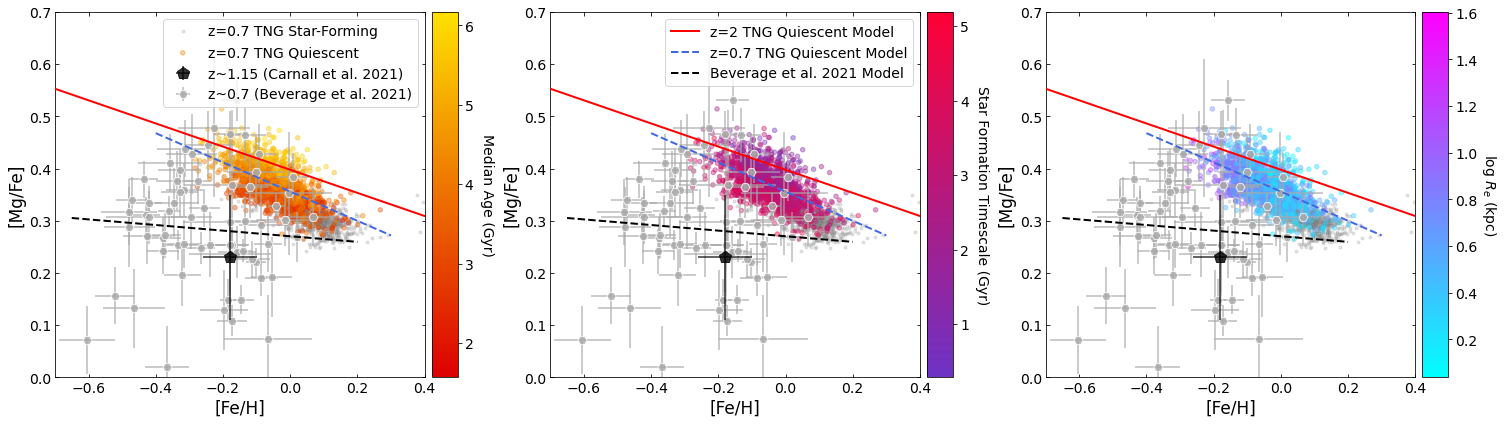

In [59]:

# [Mg/Fe] vs [Fe/H]
####################
fig, axes = plt.subplots(1, 3, figsize=(21,6))
ax1 = axes[0]
ax2 = axes[1]

def func(x, m, b):
    y = m*x + b
    return y

markersize = 6
alpha = 0.2

### MEDIAN AGE ########
vmin_med = min(median_age[quiescent_selection])
vmax_med = max(median_age[quiescent_selection])
hexlist = ['#dd0000', '#ffe200']
colormap_med = get_continuous_cmap(hexlist)
# colormap_med = plt.get_cmap('summer')
norm_med = colors.Normalize(vmin=vmin_med, vmax=vmax_med)
color_med = colormap_med(norm_med(median_age[quiescent_selection]))

### 90 - 10 AGE ########
vmin_age = min(percentile_age[quiescent_selection])
vmax_age = max(percentile_age[quiescent_selection])
hexlist = ['#6d33c6', '#Ff0036']# '#fb2047']
colormap_age = get_continuous_cmap(hexlist)
# colormap_age = plt.get_cmap('summer')
norm_age = colors.Normalize(vmin=vmin_age, vmax=vmax_age)
color_age = colormap_age(norm_age(percentile_age[quiescent_selection]))

### 90 - 10 AGE ########
radius_quiescent = np.log10(np.array(halfmass_radius[quiescent_selection]))
vmin_r = min(radius_quiescent)
vmax_r = max(radius_quiescent)
colormap_r = plt.get_cmap('cool')
norm_r = colors.Normalize(vmin=vmin_r, vmax=vmax_r)
color_r = colormap_r(norm_r(radius_quiescent))

colormaps = [colormap_med, colormap_age, colormap_r]
colorlist = [color_med, color_age, color_r]
normlist = [norm_med, norm_age, norm_r]
cbar_labels = ['Median Age (Gyr)', 'Star Formation Timescale (Gyr)', 'log $R_e$ (kpc)']

# z=2 galaxies
# print(median_age)

#model fit
optParam, pcov = curve_fit(func, FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection])
optParam2, pcov2 = curve_fit(func, bev21['[Fe/H]'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
param = np.array([-0.22162942,  0.39764619]) # z=2
xx = np.array([-0.7, 0.4])
xx2 = np.array([-0.4, 0.3])
xx3 = np.array([-0.65, 0.2])

# optParam, pcov = curve_fit(func, FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection])
# xx = np.array([-0.7, 0.4])
# ax.plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, bev21['[Fe/H]'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
# ax.plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

models = []
points = []
i = -1
for ax in axes:
    i += 1
    # plot TNG markers
    point1, = ax.plot(FeH_Re[starforming_selection], MgFe_Re[starforming_selection], '.', color='gray',
               alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
    point2 = ax.scatter(FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection], marker='.', cmap=colormaps[i], c=colorlist[i],
               alpha=alpha+0.2, label='z='+str(redshift)+' TNG Quiescent', s=(markersize+3)**2, zorder=1)
    points.append(point1)
    points.append(point2)

    # plot models
    line1, = ax.plot(xx, func(xx, *param), '-', color='r', linewidth=2, label='z=2 TNG Quiescent Model', zorder=50000)
    line2, = ax.plot(xx2, func(xx2, *optParam), '--', color='royalblue', linewidth=2, label='z=0.7 TNG Quiescent Model', zorder=50000)
    line3, = ax.plot(xx3, func(xx3, *optParam2), '--', color='k', linewidth=2, label='Beverage et al. 2021 Model', zorder=50000)
    models.append(line1)
    models.append(line2)
    models.append(line3)

    # observations
    for s in samples:
        point = ax.errorbar(s['[Fe/H]'], s['[Mg/Fe]'], xerr=s['[Fe/H]_err'], yerr=s['[Mg/Fe]_err'], **s.meta)
        points.append(point)

    # labels
    ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]',
          ylim=[0.0, 0.7], xlim=[-0.7, 0.4])
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
    
    # colorbar
    divider = make_axes_locatable(ax)
#     fmt = mpltick.ScalarFormatter(useMathText=True)
#     fmt.set_powerlimits((0, 0))
    cax = divider.append_axes("right", size="7%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=colormaps[i], norm=normlist[i])
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax)#, format=fmt)#, format='%.0e')
#     cbar.ax.yaxis.set_offset_position('left')
    cbar.set_label(cbar_labels[i], fontsize=ftss, rotation=270, labelpad=20)
    cbar.ax.tick_params(labelsize=ftss)
#     cax.yaxis.offsetText.set_fontsize(ftss-3)

    
plt.rcParams['axes.labelsize'] = fts+1

# legend
ax1.legend(handles=points[:4], loc='upper right', fontsize=ftss).set_zorder(200)
ax2.legend(handles=[models[0], models[1], models[2]], fontsize=ftss, loc='upper right').set_zorder(200)

fig.tight_layout(w_pad=0.9)

plt.savefig('2022 FIGURES\z0p7_MgFeFeH_three.png', dpi=200, bbox_inches='tight')
plt.show()

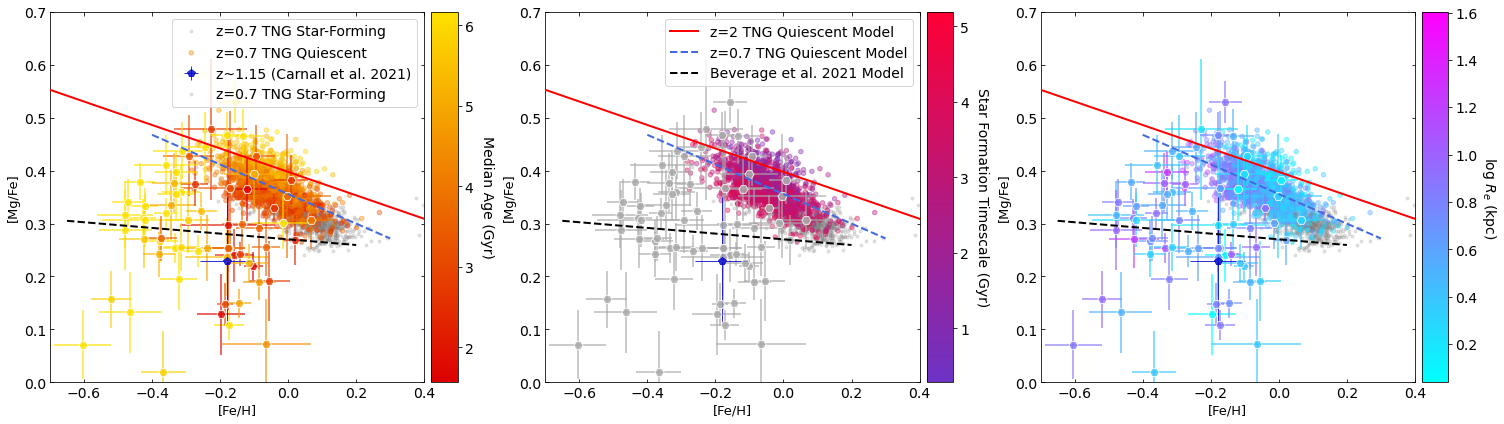

In [48]:

# [Mg/Fe] vs [Fe/H]
####################
fig, axes = plt.subplots(1, 3, figsize=(21,6))
ax1 = axes[0]
ax2 = axes[1]

samples = carn21
for s in samples:
    s.meta['linestyle'] = ''

def func(x, m, b):
    y = m*x + b
    return y

markersize = 6
alpha = 0.2
fts = 16
ftss = 14

### MEDIAN AGE ########
vmin_med = min(median_age[quiescent_selection])
vmax_med = max(median_age[quiescent_selection])
hexlist = ['#dd0000', '#ffe200']
colormap_med = get_continuous_cmap(hexlist)
# colormap_med = plt.get_cmap('summer')
norm_med = colors.Normalize(vmin=vmin_med, vmax=vmax_med)
color_med = colormap_med(norm_med(median_age[quiescent_selection]))

### 90 - 10 AGE ########
vmin_age = min(percentile_age[quiescent_selection])
vmax_age = max(percentile_age[quiescent_selection])
hexlist = ['#6d33c6', '#Ff0036']# '#fb2047']
colormap_age = get_continuous_cmap(hexlist)
# colormap_age = plt.get_cmap('summer')
norm_age = colors.Normalize(vmin=vmin_age, vmax=vmax_age)
color_age = colormap_age(norm_age(percentile_age[quiescent_selection]))

### 90 - 10 AGE ########
radius_quiescent = np.log10(np.array(halfmass_radius[quiescent_selection]))
vmin_r = min(radius_quiescent)
vmax_r = max(radius_quiescent)
colormap_r = plt.get_cmap('cool')
norm_r = colors.Normalize(vmin=vmin_r, vmax=vmax_r)
color_r = colormap_r(norm_r(radius_quiescent))

colormaps = [colormap_med, colormap_age, colormap_r]
colorlist = [color_med, color_age, color_r]
normlist = [norm_med, norm_age, norm_r]
cbar_labels = ['Median Age (Gyr)', 'Star Formation Timescale (Gyr)', 'log $R_e$ (kpc)']

# z=2 galaxies
# print(median_age)

#model fit
optParam, pcov = curve_fit(func, FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection])
optParam2, pcov2 = curve_fit(func, bev21['[Fe/H]'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
param = np.array([-0.22162942,  0.39764619]) # z=2
xx = np.array([-0.7, 0.4])
xx2 = np.array([-0.4, 0.3])
xx3 = np.array([-0.65, 0.2])

# optParam, pcov = curve_fit(func, FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection])
# xx = np.array([-0.7, 0.4])
# ax.plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, bev21['[Fe/H]'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
# ax.plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

models = []
points = []
i = -1
for ax in axes:
    i += 1
    # plot TNG markers
    point1, = ax.plot(FeH_Re[starforming_selection], MgFe_Re[starforming_selection], '.', color='gray',
               alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
    point2 = ax.scatter(FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection], marker='.', cmap=colormaps[i], c=colorlist[i],
               alpha=alpha+0.2, label='z='+str(redshift)+' TNG Quiescent', s=(markersize+3)**2, zorder=1)
    points.append(point1)
    points.append(point2)

    # plot models
    line1, = ax.plot(xx, func(xx, *param), '-', color='r', linewidth=2, label='z=2 TNG Quiescent Model', zorder=50000)
    line2, = ax.plot(xx2, func(xx2, *optParam), '--', color='royalblue', linewidth=2, label='z=0.7 TNG Quiescent Model', zorder=50000)
    line3, = ax.plot(xx3, func(xx3, *optParam2), '--', color='k', linewidth=2, label='Beverage et al. 2021 Model', zorder=50000)
    models.append(line1)
    models.append(line2)
    models.append(line3)

    # observations
    if i == 1:
        point = ax.errorbar(bev21['[Fe/H]'], bev21['[Mg/Fe]'], xerr=bev21['[Fe/H]_err'], yerr=bev21['[Mg/Fe]_err'], linestyle='',
                        color='darkgray', markersize=6+3, marker='H', alpha=0.8, zorder=100, label='z~0.7 (Beverage et al. 2021)', markeredgecolor='white')
        points.append(point)
    else:
        if i == 0:
            quantity = bev21['age']
        else:
            quantity = np.log10(bev21['Re'])
        b21color_all = colormaps[i](normlist[i](quantity))

        b21color = []
        for row in b21color_all:
            b21color.append(tuple(row))
        for m in range(len(bev21)):
            ax.errorbar(bev21['[Fe/H]'][m], bev21['[Mg/Fe]'][m], xerr=bev21['[Fe/H]_err'][m], yerr=bev21['[Mg/Fe]_err'][m],
                        color=b21color[m], markersize=6+3, marker='H', alpha=0.8, zorder=100, label='z~0.7 (Beverage et al. 2021)', markeredgecolor='white')
    for s in samples:
        point = ax.errorbar(s['[Fe/H]'], s['[Mg/Fe]'], xerr=s['[Fe/H]_err'], yerr=s['[Mg/Fe]_err'], **s.meta)
        points.append(point)
    
    # labels
    ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]',
          ylim=[0.0, 0.7], xlim=[-0.7, 0.4])
    ax.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)
    
    # colorbar
    divider = make_axes_locatable(ax)
#     fmt = mpltick.ScalarFormatter(useMathText=True)
#     fmt.set_powerlimits((0, 0))
    cax = divider.append_axes("right", size="7%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=colormaps[i], norm=normlist[i])
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax)#, format=fmt)#, format='%.0e')
#     cbar.ax.yaxis.set_offset_position('left')
    cbar.set_label(cbar_labels[i], fontsize=ftss, rotation=270, labelpad=20)
    cbar.ax.tick_params(labelsize=ftss)
#     cax.yaxis.offsetText.set_fontsize(ftss-3)

    
plt.rcParams['axes.labelsize'] = fts+1

# legend
ax1.legend(handles=points[:4], loc='upper right', fontsize=ftss).set_zorder(200)
ax2.legend(handles=[models[0], models[1], models[2]], fontsize=ftss, loc='upper right').set_zorder(200)

fig.tight_layout(w_pad=0.9)

plt.savefig('2022 FIGURES\z0p7_MgFeFeH_three_fullcolor.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:

# [Mg/Fe] vs [Fe/H]
####################
fig, axes = plt.subplots(1, 3, figsize=(6.9,2.7)) #21, 6
ax1 = axes[0]
ax2 = axes[1]

def func(x, m, b):
    y = m*x + b
    return y

markersize = 3
alpha = 0.2

### MEDIAN AGE ########
vmin_med = min(median_age[quiescent_selection])
vmax_med = max(median_age[quiescent_selection])
hexlist = ['#ffe200', '#dd0000']
colormap_med = get_continuous_cmap(hexlist)
# colormap_med = plt.get_cmap('summer')
norm_med = colors.Normalize(vmin=vmin_med, vmax=vmax_med)
color_med = colormap_med(norm_med(median_age[quiescent_selection]))

### 90 - 10 AGE ########
vmin_age = min(percentile_age[quiescent_selection])
vmax_age = max(percentile_age[quiescent_selection])
hexlist = ['#6d33c6', '#Ff0036']# '#fb2047']
colormap_age = get_continuous_cmap(hexlist)
# colormap_age = plt.get_cmap('summer')
norm_age = colors.Normalize(vmin=vmin_age, vmax=vmax_age)
color_age = colormap_age(norm_age(percentile_age[quiescent_selection]))

### 90 - 10 AGE ########
radius_quiescent = np.log10(np.array(halfmass_radius[quiescent_selection]))
vmin_r = min(radius_quiescent)
vmax_r = max(radius_quiescent)
colormap_r = plt.get_cmap('cool')
norm_r = colors.Normalize(vmin=vmin_r, vmax=vmax_r)
color_r = colormap_r(norm_r(radius_quiescent))

colormaps = [colormap_med, colormap_age, colormap_r]
colorlist = [color_med, color_age, color_r]
normlist = [norm_med, norm_age, norm_r]
cbar_labels = ['Median Age (Gyr)', 'Star Formation Timescale (Gyr)', 'log $R_e$/kpc']

# z=2 galaxies
# print(median_age)

#model fit
optParam, pcov = curve_fit(func, FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection])
xx = np.array([-0.7, 0.4])

i = -1
data = []
tng2big = []
xlims = [[-0.7, 0.4], [-0.41, 0.3], [-0.41, 0.3]]
ylims = [[0.0, 0.7], [0.25, 0.55], [0.25, 0.55]]
for ax in axes:
    i += 1
    # plot TNG markers
    tng1, = ax.plot(FeH_Re[starforming_selection], MgFe_Re[starforming_selection], '.', color='gray',
               alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
    tng2 = ax.scatter(FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection], marker='.', cmap=colormaps[i], c=colorlist[i],
               alpha=alpha+0.2, label='z='+str(redshift)+' TNG Quiescent', s=(markersize+1)**2, zorder=1)
    tng2big.append(tng2)

    # plot TNG quiescent model
    ax.plot(xx, func(xx, *optParam), '-', color='r', linewidth=1)

    # observations
    if i == 0:
        for s in samples:
            thing = ax.errorbar(s['[Fe/H]'], s['[Mg/Fe]'], xerr=s['[Fe/H]_err'], yerr=s['[Mg/Fe]_err'], **s.meta)
            data.append(thing)

    # labels
    ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]',
          ylim=ylims[i], xlim=xlims[i])
    ax.tick_params(direction='in', which='both', bottom=True, top=True, left=True, right=True, labelsize='small')
    
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="7%", pad=0.0)
    sm = plt.cm.ScalarMappable(cmap=colormaps[i], norm=normlist[i])
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')#, format=fmt)#, format='%.0e')
    cbar.outline.set_linewidth(0.5)
#     cbar.ax.yaxis.set_offset_position('left')
    cbar.set_label(cbar_labels[i], rotation=0, labelpad=-35)#, fontsize='medium')
    cbar.ax.tick_params(direction='in', labeltop=True, labelbottom=False, top=True, bottom=False, labelsize='small', width=0.5)#, length=5)

    
# plt.rcParams['axes.labelsize'] = fts+1

# legend
ax2.legend(handles=[tng1, tng2big[1]], loc='lower left', fontsize='xx-small').set_zorder(200)
leg1 = ax1.legend(handles=[data[0], data[1], data[2]], loc='lower right', fontsize='xx-small')#.set_zorder(200)
leg1.set_zorder(200)
for t in leg1.get_texts():
   t.set_multialignment('right')
# leg1._legend_box.align = "right"
# ax1.legend(loc='lower right').set_zorder(200) #, fontsize=ftss

for ax in axes:
    for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
        ax.spines[side].set_linewidth(0.5)

fig.tight_layout(w_pad=0.9)

plt.savefig('2022 FIGURES\z0p7_MgFeFeH_three_fullcolor.png', dpi=300, bbox_inches='tight')
plt.show()

In [85]:
# set the marker properties for the plots
vmin = min(percentile_age[quiescent_selection])
vmax = max(percentile_age[quiescent_selection])
colormap = plt.cm.get_cmap('rainbow')
norm = colors.Normalize(vmin=vmin, vmax=10)
k16color = colormap(norm(kriek16['age']))
k19color_all = colormap(norm(kriek19['age']))
j20color = colormap(norm(jafa20['age']))
b21color_all = colormap(norm(bev21['age']))

b21color = []
for row in b21color_all:
    b21color.append(tuple(row))

kriek16.meta['color'] = tuple(k16color[0][:])
kriek16.meta['markersize'] = 8
kriek16.meta['marker'] = 'D'
kriek16.meta['alpha'] = 0.8
kriek16.meta['zorder'] = 100

jafa20.meta['color'] = tuple(j20color[0][:])
jafa20.meta['markersize'] = 12
jafa20.meta['marker'] = 's'
jafa20.meta['alpha'] = 0.8
jafa20.meta['zorder'] = 100

carn21.meta['color'] = 'gray'
carn21.meta['markersize'] = 12
carn21.meta['marker'] = 'p'
carn21.meta['alpha'] = 0.8
carn21.meta['zorder'] = 10100


fts = 12
ftss = 11

# put z~2 samples together
samples = carn21

# this one is to suppress the line connecting points
for s in samples:
    s.meta['linestyle'] = ''

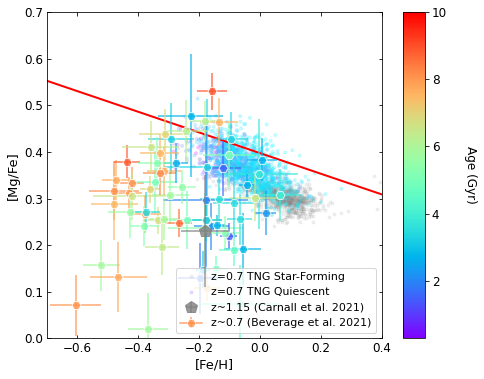

In [86]:

# [Mg/Fe] vs [Fe/H]
####################
# vmin = min(percentile_age[quiescent_selection])
# vmax = max(percentile_age[quiescent_selection])
# colormap = plt.get_cmap('rainbow')
# norm = colors.Normalize(vmin=vmin, vmax=10)
# color_quiescent = colormap(norm(percentile_age[quiescent_selection]))

param = np.array([-0.22162942,  0.39764619])

def func(x, m, b):
    y = m*x + b
    return y

fig, ax = plt.subplots(figsize=(6,6))

markersize = 6
alpha = 0.1

# z=2 galaxies
ax.plot(FeH_Re[starforming_selection], MgFe_Re[starforming_selection], '.', color='gray',
           alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
ax.scatter(FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection], marker='.', cmap='rainbow', c=color_quiescent,
           alpha=alpha+0.1, label='z='+str(redshift)+' TNG Quiescent', s=markersize**2, zorder=2)
xx = np.array([-0.7, 0.4])
ax.plot(xx, func(xx, *param), '-', color='r', linewidth=2)

# observations
for s in samples:
    ax.errorbar(s['[Fe/H]'], s['[Mg/Fe]'], xerr=s['[Fe/H]_err'], yerr=s['[Mg/Fe]_err'], **s.meta)
b21color = []
for row in b21color_all:
    b21color.append(tuple(row))
for i in range(len(bev21)):
    if i==0:
        label = 'z~0.7 (Beverage et al. 2021)'
    else:
        label = None
    ax.errorbar(bev21['[Fe/H]'][i], bev21['[Mg/Fe]'][i], xerr=bev21['[Fe/H]_err'][i], yerr=bev21['[Mg/Fe]_err'][i],
                color=b21color[i], markersize=6+3, marker='H', alpha=0.8, zorder=100, label=label, markeredgecolor='white')
    
ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]',
      ylim=[0.0, 0.7], xlim=[-0.7, 0.4])
plt.rcParams['axes.labelsize'] = fts+1
ax.tick_params(direction='in', which='both', labelsize=fts, bottom=True, top=True, left=True, right=True)
ax.legend(loc='lower right', fontsize=ftss).set_zorder(200)

# colorbar
cax = fig.add_axes([0.95, 0.125, 0.05, 0.755])
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax) #ax=axes.ravel().tolist())
cbar.set_label('Age (Gyr)', fontsize=fts, rotation=270, labelpad=30)
cbar.ax.tick_params(labelsize=fts)

plt.savefig('2022 FIGURES\z0p7_MgFeFeH_age.png', dpi=200, bbox_inches='tight')
plt.show()

In [83]:
# set the marker properties for the plots
radius_quiescent = np.array(halfmass_radius[quiescent_selection])
vmin = min(radius_quiescent)
vmax = max(radius_quiescent)
colormap = plt.get_cmap('cool')
norm = colors.Normalize(vmin=vmin, vmax=20)
k16color = colormap(norm(kriek16['Re']))
k19color_all = colormap(norm(kriek19['Re']))
j20color = colormap(norm(jafa20['Re']))
b21color_all = colormap(norm(bev21['Re']))

b21color = []
for row in b21color_all:
    b21color.append(tuple(row))

kriek16.meta['color'] = tuple(k16color[0][:])
kriek16.meta['markersize'] = 8
kriek16.meta['marker'] = 'D'
kriek16.meta['alpha'] = 0.8
kriek16.meta['zorder'] = 100

jafa20.meta['color'] = tuple(j20color[0][:])
jafa20.meta['markersize'] = 12
jafa20.meta['marker'] = 's'
jafa20.meta['alpha'] = 0.8
jafa20.meta['zorder'] = 100

carn21.meta['color'] = 'gray'
carn21.meta['markersize'] = 12
carn21.meta['marker'] = 'p'
carn21.meta['alpha'] = 0.8
carn21.meta['zorder'] = 10100


fts = 12
ftss = 11

# put z~2 samples together
samples = carn21

# this one is to suppress the line connecting points
for s in samples:
    s.meta['linestyle'] = ''

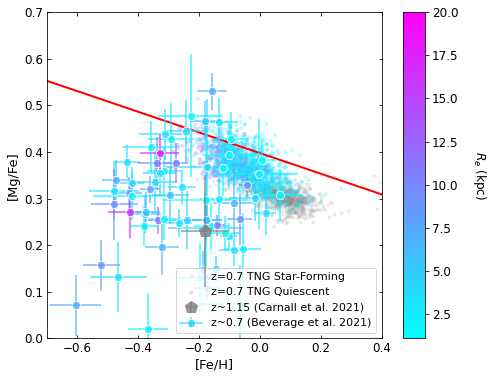

In [84]:

# [Mg/Fe] vs [Fe/H]
####################
radius_quiescent = np.array(halfmass_radius[quiescent_selection])
vmin = min(radius_quiescent)
vmax = max(radius_quiescent)
colormap = plt.get_cmap('cool')
norm = colors.Normalize(vmin=vmin, vmax=20)
color_quiescent = colormap(norm(radius_quiescent))

param = np.array([-0.22162942,  0.39764619])

def func(x, m, b):
    y = m*x + b
    return y

fig, ax = plt.subplots(figsize=(6,6))

markersize = 6
alpha = 0.1

# z=2 galaxies
ax.plot(FeH_Re[starforming_selection], MgFe_Re[starforming_selection], '.', color='gray',
           alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
ax.scatter(FeH_Re[quiescent_selection], MgFe_Re[quiescent_selection], marker='.', cmap='cool', c=color_quiescent,
           alpha=alpha+0.1, label='z='+str(redshift)+' TNG Quiescent', s=markersize**2, zorder=2)
xx = np.array([-0.7, 0.4])
ax.plot(xx, func(xx, *param), '-', color='r', linewidth=2)

# observations
for s in samples:
    ax.errorbar(s['[Fe/H]'], s['[Mg/Fe]'], xerr=s['[Fe/H]_err'], yerr=s['[Mg/Fe]_err'], **s.meta)

for i in range(len(bev21)):
    if i==0:
        label = 'z~0.7 (Beverage et al. 2021)'
    else:
        label = None
    ax.errorbar(bev21['[Fe/H]'][i], bev21['[Mg/Fe]'][i], xerr=bev21['[Fe/H]_err'][i], yerr=bev21['[Mg/Fe]_err'][i],
                color=b21color[i], markersize=6+3, marker='H', alpha=0.8, zorder=100, label=label, markeredgecolor='white')
    
ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]',
      ylim=[0.0, 0.7], xlim=[-0.7, 0.4])
plt.rcParams['axes.labelsize'] = fts+1
ax.tick_params(direction='in', which='both', labelsize=fts, bottom=True, top=True, left=True, right=True)
ax.legend(loc='lower right', fontsize=ftss).set_zorder(200)

# colorbar
cax = fig.add_axes([0.95, 0.125, 0.05, 0.755])
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax) #ax=axes.ravel().tolist())
cbar.set_label('$R_e$ (kpc)', fontsize=fts, rotation=270, labelpad=30)
cbar.ax.tick_params(labelsize=fts)

plt.savefig('2022 FIGURES\z0p7_MgFeFeH_size.png', dpi=200, bbox_inches='tight')
plt.show()

[Text(0.5, 0, 'log $R_e / kpc$'),
 Text(0, 0.5, '[Mg/H]'),
 (-0.8, 0.8),
 (-0.5, 1.0)]

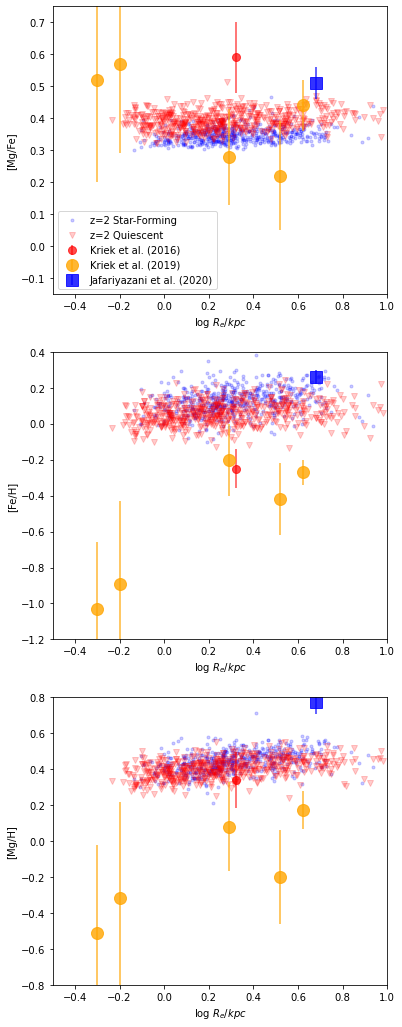

In [38]:

# plot of abundances vs effective size

fig, axs = plt.subplots(3, 1, figsize=(6,18))


# [Mg/Fe]
##########

# z=2 galaxies
axs[0].plot(np.log10(halfmass_radius[starforming_selection]), MgFe_1kpc[starforming_selection], 'b.', 
            alpha=0.2, label='z=2 Star-Forming', markersize=markersize, zorder=0)
axs[0].plot(np.log10(halfmass_radius[quiescent_selection]), MgFe_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, label='z=2 Quiescent', markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[0].errorbar(np.log10(s['Re']), s['[Mg/Fe]'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[-0.5, 1.0])
axs[0].legend(loc='lower left')



# [Fe/H]
##########

# z=2 galaxies
axs[1].plot(np.log10(halfmass_radius[starforming_selection]), FeH_1kpc[starforming_selection], 'b.', 
            alpha=0.2, markersize=markersize, zorder=0)
axs[1].plot(np.log10(halfmass_radius[quiescent_selection]), FeH_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[1].errorbar(np.log10(s['Re']), s['[Fe/H]'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1].set(xlabel=r'log $R_e / kpc$', ylabel='[Fe/H]',
      ylim=[-1.2, 0.4], xlim=[-0.5, 1.0])


# [Mg/H]
##########

# z=2 galaxies
axs[2].plot(np.log10(halfmass_radius[starforming_selection]), MgH_1kpc[starforming_selection], 'b.', 
            alpha=0.2, markersize=markersize, zorder=0)
axs[2].plot(np.log10(halfmass_radius[quiescent_selection]), MgH_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[2].errorbar(np.log10(s['Re']), s['[Mg/H]'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/H]',
      ylim=[-0.8, 0.8], xlim=[-0.5, 1.0])


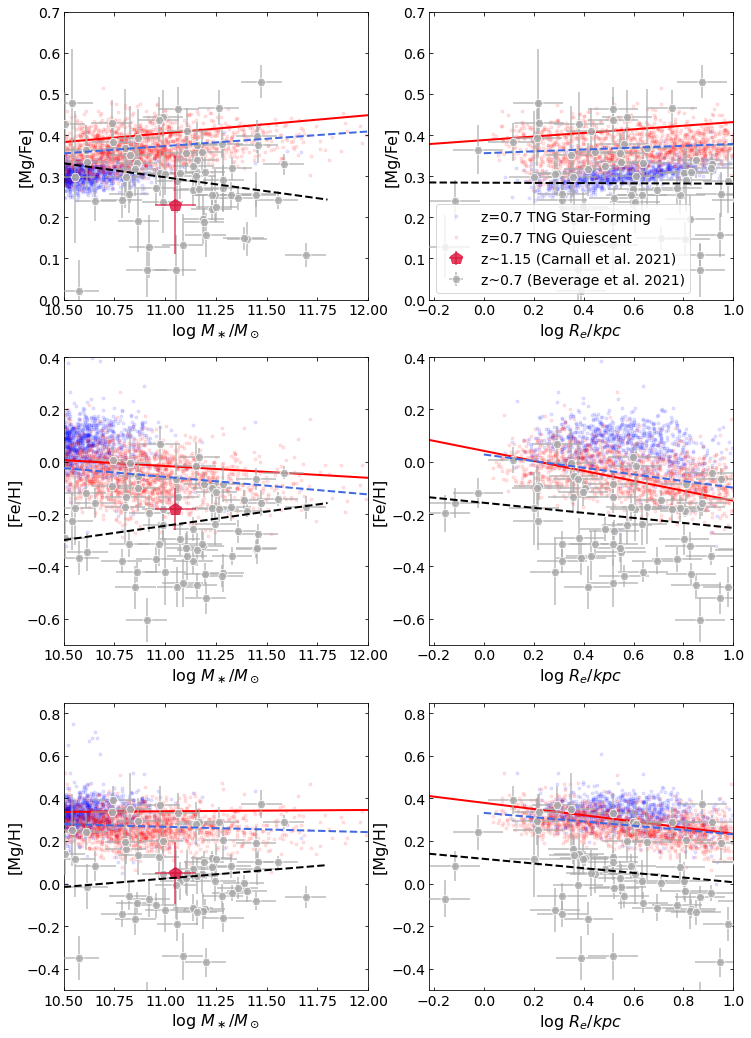

In [70]:

# plot of abundances vs stellar mass and effective size

fig, axs = plt.subplots(3, 2, figsize=(12,18))
markersize = 6
alpha = 0.1

def func(x, m, b):
    y = m*x + b
    return y

params = [np.array([ 0.0436658 , -0.07542444]), np.array([-0.04506826,  0.47971148]), np.array([0.00617531, 0.27186572]), 
          np.array([0.04384329, 0.3879252 ]), np.array([-0.19065109,  0.04186939]), np.array([-0.14510287,  0.37942294])]

##### STELLAR MASS #######################################################################

# [Mg/Fe]
##########

# z=2 galaxies
axs[0][0].plot(total_mass[starforming_selection], MgFe_Re[starforming_selection], 'b.',
           alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
axs[0][0].plot(total_mass[quiescent_selection], MgFe_Re[quiescent_selection], 'r.',
           alpha=alpha, label='z='+str(redshift)+' TNG Quiescent', markersize=markersize, zorder=0)

xx = np.array([10.5, 12])
axs[0][0].plot(xx, func(xx, *params[0]), '-', color='r', linewidth=2)
optParam, pcov = curve_fit(func, total_mass[quiescent_selection], MgFe_Re[quiescent_selection])
optParam2, pcov2 = curve_fit(func, bev21['logMstar'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
xx2 = xx
xx3 = np.array([10.5, 11.8])
axs[0][0].plot(xx2, func(xx2, *optParam), '--', color='royalblue', linewidth=2, zorder=1000)
axs[0][0].plot(xx3, func(xx3, *optParam2), '--', color='black', linewidth=2, zorder=1000)

#fit line
# optParam, pcov = curve_fit(func, total_mass[quiescent_selection], MgFe_Re[quiescent_selection])
# axs[0][0].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, bev21['logMstar'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
# axs[0][0].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

# print('TNG fit, Bev21 fit ([m b])')
# print('ax[0][0]')
# print(optParam, optParam2)


# observations
for s in samples:
    axs[0][0].errorbar(s['logMstar'], s['[Mg/Fe]'], xerr=s['x_err'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/Fe]',
      ylim=[0, 0.7], xlim=[10.5, 12])



# [Fe/H]
##########

# z=2 galaxies
axs[1][0].plot(total_mass[starforming_selection], FeH_Re[starforming_selection], 'b.',
           alpha=alpha, markersize=markersize, zorder=0)
axs[1][0].plot(total_mass[quiescent_selection], FeH_Re[quiescent_selection], 'r.',
           alpha=alpha, markersize=markersize, zorder=0)

xx = np.array([10.5, 12])
axs[1][0].plot(xx, func(xx, *params[1]), '-', color='r', linewidth=2)
optParam, pcov = curve_fit(func, total_mass[quiescent_selection], FeH_Re[quiescent_selection])
optParam2, pcov2 = curve_fit(func, bev21['logMstar'], bev21['[Fe/H]'], sigma=bev21['[Fe/H]_err'])
axs[1][0].plot(xx2, func(xx2, *optParam), '--', color='royalblue', linewidth=2, zorder=1000)
axs[1][0].plot(xx3, func(xx3, *optParam2), '--', color='black', linewidth=2, zorder=1000)

# #fit line
# optParam, pcov = curve_fit(func, total_mass[quiescent_selection], FeH_Re[quiescent_selection])
# axs[1][0].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, bev21['logMstar'], bev21['[Fe/H]'], sigma=bev21['[Fe/H]_err'])
# axs[1][0].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

# print('ax[1][0]')
# print(optParam, optParam2)

# observations
for s in samples:
    axs[1][0].errorbar(s['logMstar'], s['[Fe/H]'], xerr=s['x_err'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Fe/H]',
      ylim=[-0.7, 0.4], xlim=[10.5, 12])


# [Mg/H]
##########

# z=2 galaxies
axs[2][0].plot(total_mass[starforming_selection], MgH_Re[starforming_selection], 'b.',
           alpha=alpha, markersize=markersize, zorder=0)
axs[2][0].plot(total_mass[quiescent_selection], MgH_Re[quiescent_selection], 'r.',
           alpha=alpha, markersize=markersize, zorder=0)

xx = np.array([10.5, 12])
axs[2][0].plot(xx, func(xx, *params[2]), '-', color='r', linewidth=2)

#fit line
optParam, pcov = curve_fit(func, total_mass[quiescent_selection], MgH_Re[quiescent_selection])
# axs[2][0].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

optParam2, pcov2 = curve_fit(func, bev21['logMstar'], bev21['[Mg/H]'], sigma=bev21['[Mg/H]_err'])
# axs[2][0].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)
axs[2][0].plot(xx2, func(xx2, *optParam), '--', color='royalblue', linewidth=2, zorder=1000)
axs[2][0].plot(xx3, func(xx3, *optParam2), '--', color='black', linewidth=2, zorder=1000)
# print('ax[2][0]')
# print(optParam, optParam2)

# observations
for s in samples:
    axs[2][0].errorbar(s['logMstar'], s['[Mg/H]'], xerr=s['x_err'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/H]',
      ylim=[-0.5, 0.85], xlim=[10.5, 12])


##### EFFECTIVE SIZE ########################################################################

# [Mg/Fe]
##########

# z=2 galaxies
axs[0][1].plot(np.log10(halfmass_radius[starforming_selection]), MgFe_Re[starforming_selection], 'b.', 
            alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
axs[0][1].plot(np.log10(halfmass_radius[quiescent_selection]), MgFe_Re[quiescent_selection], 'r.', 
            alpha=alpha, label='z='+str(redshift)+' TNG Quiescent', markersize=markersize, zorder=0)

xx = np.array([-0.22, 1.0])
axs[0][1].plot(xx, func(xx, *params[3]), '-', color='r', linewidth=2)

#fit line
optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), MgFe_Re[quiescent_selection])
# axs[0][1].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

optParam2, pcov2 = curve_fit(func, np.log10(bev21['Re']), bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
# axs[0][1].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)
xx2 = np.array([0.0, 1.0])
xx3 = xx
axs[0][1].plot(xx2, func(xx2, *optParam), '--', color='royalblue', linewidth=2, zorder=1000)
axs[0][1].plot(xx3, func(xx3, *optParam2), '--', color='black', linewidth=2, zorder=1000)
# print('ax[0][1]')
# print(optParam, optParam2)

# observations
for s in samples:
    axs[0][1].errorbar(np.log10(s['Re']), s['[Mg/Fe]'], xerr=s['x_err'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/Fe]',
      ylim=[0, 0.7], xlim=[-0.22, 1.0])
axs[0][1].legend(loc='lower left', fontsize=ftss).set_zorder(200)


# [Fe/H]
##########

# z=2 galaxies
axs[1][1].plot(np.log10(halfmass_radius[starforming_selection]), FeH_Re[starforming_selection], 'b.', 
            alpha=alpha, markersize=markersize, zorder=0)
axs[1][1].plot(np.log10(halfmass_radius[quiescent_selection]), FeH_Re[quiescent_selection], 'r.', 
            alpha=alpha, markersize=markersize, zorder=0)

xx = np.array([-0.22, 1.0])
axs[1][1].plot(xx, func(xx, *params[4]), '-', color='r', linewidth=2)

# #fit line
optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), FeH_Re[quiescent_selection])
# axs[1][1].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

optParam2, pcov2 = curve_fit(func, np.log10(bev21['Re']), bev21['[Fe/H]'], sigma=bev21['[Fe/H]_err'])
# axs[1][1].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)
axs[1][1].plot(xx2, func(xx2, *optParam), '--', color='royalblue', linewidth=2, zorder=1000)
axs[1][1].plot(xx3, func(xx3, *optParam2), '--', color='black', linewidth=2, zorder=1000)
# print('ax[1][1]')
# print(optParam, optParam2)

# observations
for s in samples:
    axs[1][1].errorbar(np.log10(s['Re']), s['[Fe/H]'], xerr=s['x_err'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Fe/H]',
      ylim=[-0.7, 0.4], xlim=[-0.22, 1.0])


# [Mg/H]
##########

# z=2 galaxies
axs[2][1].plot(np.log10(halfmass_radius[starforming_selection]), MgH_Re[starforming_selection], 'b.', 
            alpha=alpha, markersize=markersize, zorder=0)
axs[2][1].plot(np.log10(halfmass_radius[quiescent_selection]), MgH_Re[quiescent_selection], 'r.', 
            alpha=alpha, markersize=markersize, zorder=0)

xx = np.array([-0.22, 1.0])
axs[2][1].plot(xx, func(xx, *params[5]), '-', color='r', linewidth=2)

#fit line
optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), MgH_Re[quiescent_selection])
# axs[2][1].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

optParam2, pcov2 = curve_fit(func, np.log10(bev21['Re']), bev21['[Mg/H]'], sigma=bev21['[Mg/H]_err'])
# axs[2][1].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)
axs[2][1].plot(xx2, func(xx2, *optParam), '--', color='royalblue', linewidth=2, zorder=1000)
axs[2][1].plot(xx3, func(xx3, *optParam2), '--', color='black', linewidth=2, zorder=1000)
# print('ax[2][1]')
# print(optParam, optParam2)

# observations
for s in samples:
    axs[2][1].errorbar(np.log10(s['Re']), s['[Mg/H]'], xerr=s['x_err'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/H]',
      ylim=[-0.5, 0.85], xlim=[-0.22, 1.0])

plt.rcParams['axes.labelsize'] = fts
for bip in axs:
    for bop in bip:
        bop.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

plt.savefig('2022 FIGURES\z0p7_bigcheddar.png', dpi=100, bbox_inches='tight')
plt.show()

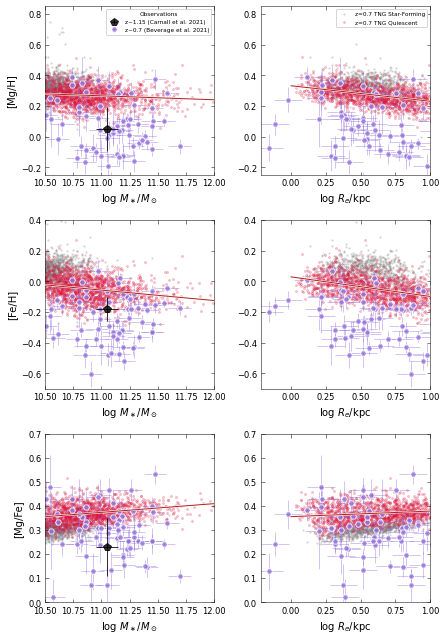

In [41]:
import matplotlib.patheffects as pe

# plot of abundances vs stellar mass and effective size

fig, axs = plt.subplots(3, 2, figsize=(6.3,9), sharey='row')
markersize = 3
alpha = 0.2
linewidth = 1

def func(x, m, b):
    y = m*x + b
    return y

params = []
color2 = 'firebrick'
color3 = 'darkslateblue'
color1 = 'crimson'
lw = 1

patheffects = [pe.Stroke(linewidth=2, foreground='w'), pe.Normal()]

##### STELLAR MASS #######################################################################

# [Mg/Fe]
##########

# z=2 galaxies
axs[2][0].plot(total_mass[starforming_selection], MgFe_Re[starforming_selection], '.', color='gray',
           alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
axs[2][0].plot(total_mass[quiescent_selection], MgFe_Re[quiescent_selection], '.', color=color1,
           alpha=alpha, label='z='+str(redshift)+' TNG Quiescent', markersize=markersize+1, zorder=1)

xx2 = np.array([10.5, 12])
xx3 = np.array([10.5, 11.8])
#fit line
optParam, pcov = curve_fit(func, total_mass[quiescent_selection], MgFe_Re[quiescent_selection])
# optParam2, pcov2 = curve_fit(func, bev21['logMstar'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
axs[2][0].plot(xx2, func(xx2, *optParam), '-', color=color2, linewidth=lw, zorder=1000, path_effects=patheffects)
# axs[2][0].plot(xx3, func(xx3, *optParam2), '-', color=color3, linewidth=lw, zorder=1000, path_effects=patheffects)


# observations
obsarray = []
for s in samples:
    thing = axs[2][0].errorbar(s['logMstar'], s['[Mg/Fe]'], xerr=s['x_err'], yerr=s['[Mg/Fe]_err'], **s.meta)
    obsarray.append(thing)
    
axs[2][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/Fe]',
      ylim=[0, 0.7], xlim=[10.5, 12])



# [Fe/H]
##########

# z=2 galaxies
axs[1][0].plot(total_mass[starforming_selection], FeH_Re[starforming_selection], '.', color='gray',
           alpha=alpha, markersize=markersize, zorder=0)
axs[1][0].plot(total_mass[quiescent_selection], FeH_Re[quiescent_selection], '.', color=color1,
           alpha=alpha, markersize=markersize+1, zorder=1)

#fit line
optParam, pcov = curve_fit(func, total_mass[quiescent_selection], FeH_Re[quiescent_selection])
# optParam2, pcov2 = curve_fit(func, bev21['logMstar'], bev21['[Fe/H]'], sigma=bev21['[Fe/H]_err'])
axs[1][0].plot(xx2, func(xx2, *optParam), '-', color=color2, linewidth=lw, zorder=1000, path_effects=patheffects)
# axs[1][0].plot(xx3, func(xx3, *optParam2), '-', color=color3, linewidth=lw, zorder=1000, path_effects=patheffects)


# observations
for s in samples:
    axs[1][0].errorbar(s['logMstar'], s['[Fe/H]'], xerr=s['x_err'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Fe/H]',
      ylim=[-0.7, 0.4], xlim=[10.5, 12])


# [Mg/H]
##########

# z=2 galaxies
axs[0][0].plot(total_mass[starforming_selection], MgH_Re[starforming_selection], '.', color='gray',
           label='z='+str(redshift)+' TNG Star-Forming', alpha=alpha, markersize=markersize, zorder=0)
axs[0][0].plot(total_mass[quiescent_selection], MgH_Re[quiescent_selection], '.', color=color1,
           label='z='+str(redshift)+' TNG Quiescent', alpha=alpha, markersize=markersize+1, zorder=1)

#fit line
optParam, pcov = curve_fit(func, total_mass[quiescent_selection], MgH_Re[quiescent_selection])
# optParam2, pcov2 = curve_fit(func, bev21['logMstar'], bev21['[Mg/H]'], sigma=bev21['[Mg/H]_err'])
axs[0][0].plot(xx2, func(xx2, *optParam), '-', color=color2, linewidth=lw, zorder=1000, path_effects=patheffects)
# axs[0][0].plot(xx3, func(xx3, *optParam2), '-', color=color3, linewidth=lw, zorder=1000, path_effects=patheffects)

# observations
for s in samples:
    axs[0][0].errorbar(s['logMstar'], s['[Mg/H]'], xerr=s['x_err'], yerr=s['[Mg/H]_err'], **s.meta)

axs[0][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/H]',
      ylim=[0.85-1.1, 0.85], xlim=[10.5, 12])


##### EFFECTIVE SIZE ########################################################################

# [Mg/Fe]
##########

# z=2 galaxies
axs[2][1].plot(np.log10(halfmass_radius[starforming_selection]), MgFe_Re[starforming_selection], '.', color='gray', 
            alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
axs[2][1].plot(np.log10(halfmass_radius[quiescent_selection]), MgFe_Re[quiescent_selection], '.', color=color1, 
            alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize+1, zorder=1)

xx3 = np.array([-0.22, 1.0])
xx2 = np.array([0.0, 1.0])
#fit line
optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), MgFe_Re[quiescent_selection])
# optParam2, pcov2 = curve_fit(func, bev21['Re'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
axs[2][1].plot(xx2, func(xx2, *optParam), '-', color=color2, linewidth=lw, zorder=1000, path_effects=patheffects)
# axs[2][1].plot(xx3, func(xx3, *optParam2), '-', color=color3, linewidth=lw, zorder=1000, path_effects=patheffects)



# observations
for s in samples:
    axs[2][1].errorbar(np.log10(s['Re']), s['[Mg/Fe]'], xerr=s['x_err'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[2][1].set(xlabel=r'log $R_e$/kpc', ylabel=None,
      ylim=[0, 0.7], xlim=[-0.22, 1.0])



# [Fe/H]
##########

# z=2 galaxies
axs[1][1].plot(np.log10(halfmass_radius[starforming_selection]), FeH_Re[starforming_selection], '.', color='gray', 
            alpha=alpha, markersize=markersize, zorder=0)
axs[1][1].plot(np.log10(halfmass_radius[quiescent_selection]), FeH_Re[quiescent_selection], '.', color=color1,
            alpha=alpha, markersize=markersize+1, zorder=1)

#fit line
optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), FeH_Re[quiescent_selection])
# optParam2, pcov2 = curve_fit(func, bev21['Re'], bev21['[Fe/H]'], sigma=bev21['[Fe/H]_err'])
axs[1][1].plot(xx2, func(xx2, *optParam), '-', color=color2, linewidth=lw, zorder=1000, path_effects=patheffects)
# axs[1][1].plot(xx3, func(xx3, *optParam2), '-', color=color3, linewidth=lw, zorder=1000, path_effects=patheffects)


# observations
for s in samples:
    axs[1][1].errorbar(np.log10(s['Re']), s['[Fe/H]'], xerr=s['x_err'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1][1].set(xlabel=r'log $R_e$/kpc', ylabel=None,
      ylim=[-0.7, 0.4], xlim=[-0.22, 1.0])


# [Mg/H]
##########
otharray = []
# z=2 galaxies
tngsf, = axs[0][1].plot(np.log10(halfmass_radius[starforming_selection]), MgH_Re[starforming_selection], '.', color='gray', 
            label='z='+str(redshift)+' TNG Star-Forming', alpha=alpha, markersize=markersize, zorder=0)
tngq, = axs[0][1].plot(np.log10(halfmass_radius[quiescent_selection]), MgH_Re[quiescent_selection], '.', color=color1, 
            label='z='+str(redshift)+' TNG Quiescent', alpha=alpha, markersize=markersize+1, zorder=1)

#fit line
optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), MgH_Re[quiescent_selection])
# optParam2, pcov2 = curve_fit(func, bev21['Re'], bev21['[Mg/H]'], sigma=bev21['[Mg/H]_err'])
line1, = axs[0][1].plot(xx2, func(xx2, *optParam), '-', color=color2, linewidth=lw, zorder=1000, path_effects=patheffects,
                       label='z=0.7 Relation')
# line2, = axs[0][1].plot(xx3, func(xx3, *optParam2), '-', color=color3, linewidth=lw, zorder=1000, path_effects=patheffects,
#                        label='Beverage et al. (2021) Relation')

otharray.append(tngsf)
otharray.append(tngq)
# otharray.append(line1)
# otharray.append(line2)

# observations
for s in samples:
    axs[0][1].errorbar(np.log10(s['Re']), s['[Mg/H]'], xerr=s['x_err'], yerr=s['[Mg/H]_err'], **s.meta)

axs[0][1].set(xlabel=r'log $R_e$/kpc', ylabel=None,
      ylim=[0.85-1.1, 0.85], xlim=[-0.22, 1.0])

plt.rcParams['axes.labelsize'] = fts
for bip in axs:
    for bop in bip:
        bop.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True, width=0.5)
        
# legend
axs[0][0].legend(title='Observations', handles=[obsarray[0], obsarray[1]], title_fontsize=ftsss, loc='upper right', fontsize=ftsss).set_zorder(200)
axs[0][1].legend(handles=[otharray[0], otharray[1]], loc='upper right', fontsize=ftsss).set_zorder(200) #, otharray[2], otharray[3]

for row in axs:
    for ax in row:
        ax.yaxis.set_tick_params(labelbottom=True)
        for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
            ax.spines[side].set_linewidth(0.5)
        
fig.tight_layout()

plt.savefig('2022 FIGURES\z0p7_bigcheddar.png', dpi=300, bbox_inches='tight')
plt.show()

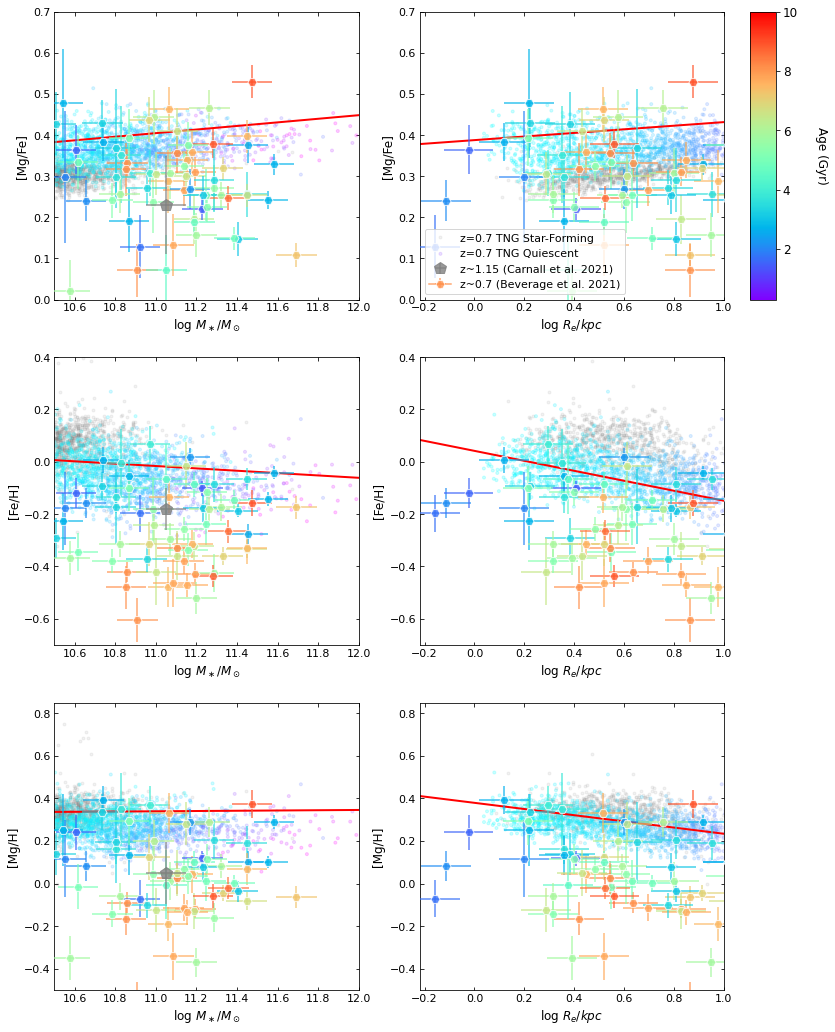

In [81]:

# plot of abundances vs stellar mass and effective size

fig, axs = plt.subplots(3, 2, figsize=(12,18))
markersize = 6
alpha = 0.1

def func(x, m, b):
    y = m*x + b
    return y

params = [np.array([ 0.0436658 , -0.07542444]), np.array([-0.04506826,  0.47971148]), np.array([0.00617531, 0.27186572]), 
          np.array([0.04384329, 0.3879252 ]), np.array([-0.19065109,  0.04186939]), np.array([-0.14510287,  0.37942294])]

##### STELLAR MASS #######################################################################

# [Mg/Fe]
##########

# z=2 galaxies
axs[0][0].plot(total_mass[starforming_selection], MgFe_Re[starforming_selection], '.', color='gray',
           alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
axs[0][0].scatter(total_mass[quiescent_selection], MgFe_Re[quiescent_selection], marker='.', cmap='cool', c=color_quiescent,
           alpha=alpha+0.1, s=markersize**2, zorder=2)

xx = np.array([10.5, 12])
axs[0][0].plot(xx, func(xx, *params[0]), '-', color='r', linewidth=2)

#fit line
# optParam, pcov = curve_fit(func, total_mass[quiescent_selection], MgFe_Re[quiescent_selection])
# axs[0][0].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, bev21['logMstar'], bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
# axs[0][0].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

# print('TNG fit, Bev21 fit ([m b])')
# print('ax[0][0]')
# print(optParam, optParam2)


# observations
for s in samples:
    axs[0][0].errorbar(s['logMstar'], s['[Mg/Fe]'], xerr=s['x_err'], yerr=s['[Mg/Fe]_err'], **s.meta)
for i in range(len(bev21)):
    axs[0][0].errorbar(bev21['logMstar'][i], bev21['[Mg/Fe]'][i], xerr=bev21['x_err'][i], yerr=bev21['[Mg/Fe]_err'][i],
                color=b21color[i], markersize=6+3, marker='H', alpha=0.8, zorder=100, markeredgecolor='white')
    
axs[0][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/Fe]',
      ylim=[0, 0.7], xlim=[10.5, 12])



# [Fe/H]
##########

# z=2 galaxies
axs[1][0].plot(total_mass[starforming_selection], FeH_Re[starforming_selection], '.', color='gray',
           alpha=alpha, markersize=markersize, zorder=0)
axs[1][0].scatter(total_mass[quiescent_selection], FeH_Re[quiescent_selection], marker='.', cmap='cool', c=color_quiescent,
           alpha=alpha+0.1, s=markersize**2, zorder=2)

xx = np.array([10.5, 12])
axs[1][0].plot(xx, func(xx, *params[1]), '-', color='r', linewidth=2)

# #fit line
# optParam, pcov = curve_fit(func, total_mass[quiescent_selection], FeH_Re[quiescent_selection])
# axs[1][0].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, bev21['logMstar'], bev21['[Fe/H]'], sigma=bev21['[Fe/H]_err'])
# axs[1][0].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

# print('ax[1][0]')
# print(optParam, optParam2)

# observations
for s in samples:
    axs[1][0].errorbar(s['logMstar'], s['[Fe/H]'], xerr=s['x_err'], yerr=s['[Fe/H]_err'], **s.meta)
for i in range(len(bev21)):
    axs[1][0].errorbar(bev21['logMstar'][i], bev21['[Fe/H]'][i], xerr=bev21['x_err'][i], yerr=bev21['[Fe/H]_err'][i],
                color=b21color[i], markersize=6+3, marker='H', alpha=0.8, zorder=100, markeredgecolor='white')
    
axs[1][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Fe/H]',
      ylim=[-0.7, 0.4], xlim=[10.5, 12])


# [Mg/H]
##########

# z=2 galaxies
axs[2][0].plot(total_mass[starforming_selection], MgH_Re[starforming_selection], '.', color='gray',
           alpha=alpha, markersize=markersize, zorder=0)
axs[2][0].scatter(total_mass[quiescent_selection], MgH_Re[quiescent_selection], marker='.', cmap='cool', c=color_quiescent,
           alpha=alpha+0.1, s=markersize**2, zorder=2)

xx = np.array([10.5, 12])
axs[2][0].plot(xx, func(xx, *params[2]), '-', color='r', linewidth=2)

#fit line
# optParam, pcov = curve_fit(func, total_mass[quiescent_selection], MgH_Re[quiescent_selection])
# axs[2][0].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, bev21['logMstar'], bev21['[Mg/H]'], sigma=bev21['[Mg/H]_err'])
# axs[2][0].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

# print('ax[2][0]')
# print(optParam, optParam2)

# observations
for s in samples:
    axs[2][0].errorbar(s['logMstar'], s['[Mg/H]'], xerr=s['x_err'], yerr=s['[Mg/H]_err'], **s.meta)
for i in range(len(bev21)):
    axs[2][0].errorbar(bev21['logMstar'][i], bev21['[Mg/H]'][i], xerr=bev21['x_err'][i], yerr=bev21['[Mg/H]_err'][i],
                color=b21color[i], markersize=6+3, marker='H', alpha=0.8, zorder=100, markeredgecolor='white')
    
axs[2][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/H]',
      ylim=[-0.5, 0.85], xlim=[10.5, 12])


##### EFFECTIVE SIZE ########################################################################

# [Mg/Fe]
##########

# z=2 galaxies
axs[0][1].plot(np.log10(halfmass_radius[starforming_selection]), MgFe_Re[starforming_selection], '.', color='gray', 
            alpha=alpha, label='z='+str(redshift)+' TNG Star-Forming', markersize=markersize, zorder=0)
axs[0][1].scatter(np.log10(halfmass_radius[quiescent_selection]), MgFe_Re[quiescent_selection], marker='.', cmap='cool', c=color_quiescent,
           alpha=alpha+0.1, label='z='+str(redshift)+' TNG Quiescent', s=markersize**2, zorder=2)

xx = np.array([-0.22, 1.0])
axs[0][1].plot(xx, func(xx, *params[3]), '-', color='r', linewidth=2)

#fit line
# optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), MgFe_Re[quiescent_selection])
# axs[0][1].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, np.log10(bev21['Re']), bev21['[Mg/Fe]'], sigma=bev21['[Mg/Fe]_err'])
# axs[0][1].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

# print('ax[0][1]')
# print(optParam, optParam2)

# observations
for s in samples:
    axs[0][1].errorbar(np.log10(s['Re']), s['[Mg/Fe]'], xerr=s['x_err'], yerr=s['[Mg/Fe]_err'], **s.meta)
for i in range(len(bev21)):
    if i==0:
        label = 'z~0.7 (Beverage et al. 2021)'
    else:
        label = None
    axs[0][1].errorbar(np.log10(bev21['Re'][i]), bev21['[Mg/Fe]'][i], xerr=bev21['x_err'][i], yerr=bev21['[Mg/Fe]_err'][i],
                color=b21color[i], markersize=6+3, marker='H', alpha=0.8, zorder=100, label=label, markeredgecolor='white')
    
axs[0][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/Fe]',
      ylim=[0, 0.7], xlim=[-0.22, 1.0])
axs[0][1].legend(loc='lower left', fontsize=ftss).set_zorder(200)


# [Fe/H]
##########

# z=2 galaxies
axs[1][1].plot(np.log10(halfmass_radius[starforming_selection]), FeH_Re[starforming_selection], '.', color='gray', 
            alpha=alpha, markersize=markersize, zorder=0)
axs[1][1].scatter(np.log10(halfmass_radius[quiescent_selection]), FeH_Re[quiescent_selection], marker='.', cmap='cool', c=color_quiescent,
           alpha=alpha+0.1, s=markersize**2, zorder=2)

xx = np.array([-0.22, 1.0])
axs[1][1].plot(xx, func(xx, *params[4]), '-', color='r', linewidth=2)

# #fit line
# optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), FeH_Re[quiescent_selection])
# axs[1][1].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, np.log10(bev21['Re']), bev21['[Fe/H]'], sigma=bev21['[Fe/H]_err'])
# axs[1][1].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

# print('ax[1][1]')
# print(optParam, optParam2)

# observations
for s in samples:
    axs[1][1].errorbar(np.log10(s['Re']), s['[Fe/H]'], xerr=s['x_err'], yerr=s['[Fe/H]_err'], **s.meta)
for i in range(len(bev21)):
    axs[1][1].errorbar(np.log10(bev21['Re'][i]), bev21['[Fe/H]'][i], xerr=bev21['x_err'][i], yerr=bev21['[Fe/H]_err'][i],
                color=b21color[i], markersize=6+3, marker='H', alpha=0.8, zorder=100, markeredgecolor='white')
    
axs[1][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Fe/H]',
      ylim=[-0.7, 0.4], xlim=[-0.22, 1.0])


# [Mg/H]
##########

# z=2 galaxies
axs[2][1].plot(np.log10(halfmass_radius[starforming_selection]), MgH_Re[starforming_selection], '.', color='gray', 
            alpha=alpha, markersize=markersize, zorder=0)
axs[2][1].scatter(np.log10(halfmass_radius[quiescent_selection]), MgH_Re[quiescent_selection], marker='.', cmap='cool', c=color_quiescent,
           alpha=alpha+0.1, s=markersize**2, zorder=2)

xx = np.array([-0.22, 1.0])
axs[2][1].plot(xx, func(xx, *params[5]), '-', color='r', linewidth=2)

#fit line
# optParam, pcov = curve_fit(func, np.log10(halfmass_radius[quiescent_selection]), MgH_Re[quiescent_selection])
# axs[2][1].plot(xx, func(xx, *optParam), '-', color='k', linewidth=2)

# optParam2, pcov2 = curve_fit(func, np.log10(bev21['Re']), bev21['[Mg/H]'], sigma=bev21['[Mg/H]_err'])
# axs[2][1].plot(xx, func(xx, *optParam2), '-', color='gray', linewidth=2)

# print('ax[2][1]')
# print(optParam, optParam2)

# observations
for s in samples:
    axs[2][1].errorbar(np.log10(s['Re']), s['[Mg/H]'], xerr=s['x_err'], yerr=s['[Mg/H]_err'], **s.meta)
for i in range(len(bev21)):
    axs[2][1].errorbar(np.log10(bev21['Re'][i]), bev21['[Mg/H]'][i], xerr=bev21['x_err'][i], yerr=bev21['[Mg/H]_err'][i],
                color=b21color[i], markersize=6+3, marker='H', alpha=0.8, zorder=100, markeredgecolor='white')
    
axs[2][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/H]',
      ylim=[-0.5, 0.85], xlim=[-0.22, 1.0])

plt.rcParams['axes.labelsize'] = fts
for bip in axs:
    for bop in bip:
        bop.tick_params(direction='in', which='both', labelsize=ftss, bottom=True, top=True, left=True, right=True)

# colorbar
cax = fig.add_axes([0.93, 0.658, 0.03, 0.222])
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax) #ax=axes.ravel().tolist())
cbar.set_label('Age (Gyr)', fontsize=fts, rotation=270, labelpad=30)
cbar.ax.tick_params(labelsize=fts)

plt.savefig('2022 FIGURES\z0p7_bigcheddar_age.png', dpi=100, bbox_inches='tight')
plt.show()